In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import infomap
from matplotlib import pyplot as plt
from matplotlib import colors
import statsmodels.api as sm
from tqdm.autonotebook import tqdm
from matplotlib.lines import Line2D
import string
from scipy.special import softmax
import seaborn as sns
import igraph as ig
import leidenalg as la
import matplotlib as mpl

/var/folders/mp/32m29kq1643bw2wj_l7slh380000gn/T/ipykernel_15834/1920386304.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Notes
- Show community structure of CCCM
- Show topic structure of climate obstructionist discourse
- Show that social structure of CCCM predicts topic similarity.


- Test whether conservative grantmaking influences topic structure of conservative orgs.


- Show that different communities appear to influence different parts of the national political apparatus. 
- Test hypothesis: conservative movement organizations influence R party platforms and presidential addresses; 
- Trade associations influence EPA and bipartisan energy discussions

To test similarity of conservative topics to published texts, use JS distance between topic distribution and word distribution within the text.

In [545]:
df_org = pd.read_csv('data/metadata.csv')
df_intr = pd.read_json('data/cccm_interlocks.json')
df_ofc = pd.read_csv('data/officers.csv')

eins = pd.read_csv('data/eins.csv')
ein_to_name = eins.set_index('EIN').ORG
name_to_ein = eins.set_index('ORG').EIN

df_intr = df_intr[~df_intr.ein1.map(ein_to_name).str.contains('MECH') &
                  ~df_intr.ein2.map(ein_to_name).str.contains('MECH')]

year_sizes = df_ofc[
    (df_ofc['class'] == 'officers') & 
    (df_ofc.year >= 2003) &
    (df_ofc.year <= 2018)
].groupby(['ein', 'year']).final_id.nunique().unstack().interpolate(axis = 0).T

E_normed_directed = pd.DataFrame(
    [
        {
            'source': ein_to_name.get(row.ein1),
            'target': ein_to_name.get(row.ein2),
            'weight': len([y for y in row.group1Years]) / year_sizes[row.ein1].median(),
        }
        for idx, row in df_intr[df_intr.Verified].iterrows()
        if (row.ein1 != row.ein2) 
    ] + 
    [
        {
            'source': ein_to_name.get(row.ein2),
            'target': ein_to_name.get(row.ein1),
            'weight': len([y for y in row.group2Years]) / year_sizes[row.ein2].median(),
        }
        for idx, row in df_intr[df_intr.Verified].iterrows()
        if (row.ein1 != row.ein2) 
    ]
).groupby(['source', 'target']).weight.sum().reset_index(drop = False)

E_normed_directed = E_normed_directed[E_normed_directed.weight > 0]

E_basic = pd.DataFrame(
    [
        {
            'source': ein_to_name.get(row.ein1),
            'target': ein_to_name.get(row.ein2),
            'weight': 1 ,
        }
        for idx, row in df_intr[df_intr.Verified].iterrows()
        if (row.ein1 != row.ein2) 
    ]
).groupby(['source', 'target']).weight.sum().reset_index(drop = False)

# multilayer_edgelist = multilayer_edgelist[multilayer_edgelist.weight > 0]
# multilayer_edgelist['weight'] = multilayer_edgelist.weight.apply(lambda w: min(w, 1))
# multilayer_edgelist = multilayer_edgelist[~multilayer_edgelist.apply(lambda r: 'MECHANICAL' in str(r), 1)]

In [546]:
E_normed = pd.DataFrame(
    [[*sorted([s,t]), w] for s,t,w in E_normed_directed.values],
    columns = ['source', 'target', 'weight']
).groupby(['source', 'target'])['weight'].mean().reset_index(drop = False)

In [551]:
G_i = nx.Graph(E_basic)
G_interlocks = G_i.subgraph(next(nx.connected_components(nx.to_undirected(G_i))))

G_to_plot = nx.Graph(E_basic)

for u,v,d in G_interlocks.edges(data = True):
    G_interlocks.edges[u,v]['distance'] = 1/d['weight']

V = list(G_interlocks.nodes)

In [552]:
im = infomap.Infomap(markov_time = 1, directed = G_interlocks.is_directed(), silent = True)
im.add_networkx_graph(G_interlocks)
im.run()

interlock_partition = im.get_dataframe(['name', 'module_id'])
interlock_partition = interlock_partition.drop_duplicates('name').set_index('name').module_id.reindex(G_interlocks)
interlock_partition.sort_values()

ACCURACY IN ACADEMIA                                1
INSTITUTE FOR POLICY INNOVATION                     1
BEACON HILL INSTITUTE FOR PUBLIC POLICY RESEARCH    1
PRAGERU (PRAGER UNIVERSITY)                         1
AYN RAND INSTITUTE                                  1
                                                   ..
INTERSTATE NATURAL GAS ASSOCIATION OF AMERICA       3
WEST VIRGINIA COAL ASSOCIATION                      3
PLANTS NEED CO2                                     3
AMERICA'S POWER                                     3
EDISON ELECTRIC INSTITUTE                           3
Name: module_id, Length: 128, dtype: int64

Text(0.5, 1.0, '$\\bf{Figure~1.}$ Communities inferred from board interlocks.')

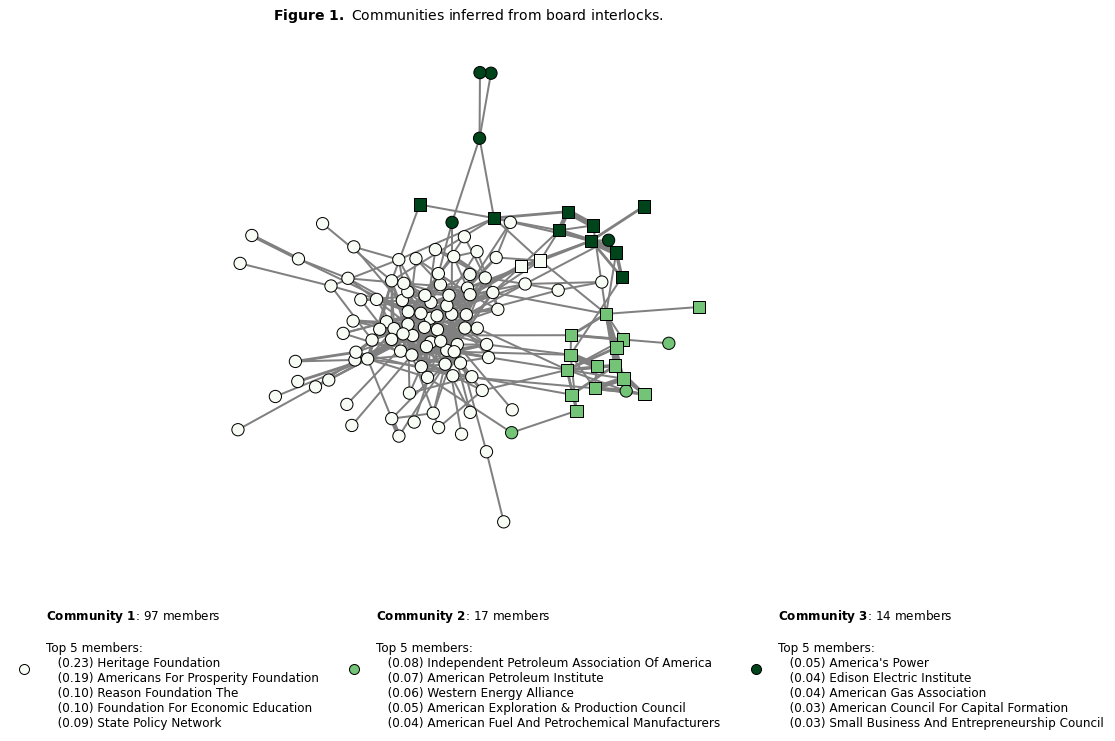

In [946]:
cmap = "Greens"
pos = nx.spring_layout(G_to_plot, k = 10, iterations = 5000, seed = 19012022)
ew = np.array([e[2]['weight']**0.5 for e in G_interlocks.edges(data = True)])

fig, ax = plt.subplots(1,1, figsize = (10,10))

orgtypes = df_org.set_index('ORG').NONPROFIT_TYPE
g1 = G_interlocks.subgraph([n for n in G_interlocks if orgtypes[n] in ('501(c)(3)', '501(c)(4)')])
g2 = G_interlocks.subgraph([n for n in G_interlocks if orgtypes[n] in ('501(c)(5)', '501(c)(6)')])

nodes = nx.draw_networkx_nodes(g1, 
                               ax = ax, 
                               pos = pos, 
                               node_color = interlock_partition.reindex(g1), 
                               node_size = 150, 
                               node_shape = 'o',
                               vmin = 1,
                               vmax = interlock_partition.max(),
                               cmap = cmap)
nodes.set_edgecolor('k')
cmap = nodes.cmap

nodes = nx.draw_networkx_nodes(g2, 
                               ax = ax, 
                               pos = pos, 
                               node_color = interlock_partition.reindex(g2), 
                               node_size = 150, 
                               node_shape = 's',
                               vmin = 1,
                               vmax = interlock_partition.max(),
                               cmap = cmap)
nodes.set_edgecolor('k')

edges = nx.draw_networkx_edges(G_interlocks, 
                               ax = ax, 
                               pos = pos, 
                               width = ew, 
                               edge_color = 'grey', 
                              )

legend_markers = [
    Line2D(
        [0],                          
        [0],                          
        mfc=nodes.cmap(nodes.norm(m)),                          
        markersize = 100**0.5,                          
        lw = 0,                          
        marker = 'o',                          
        mec = 'k'
    )  
    for m in sorted(interlock_partition.unique())
]

top_members = {}

centrality = pd.Series(dict(nx.betweenness_centrality(G_interlocks, weight = 'distance')))

for m in sorted(interlock_partition.unique()):
    V_m = interlock_partition[interlock_partition == m].index.values    
    
    top_members[m] = (
        (interlock_partition == m).sum(),
        '\n   '.join(["(%.2f) "%n + string.capwords(idx) 
                      for idx, n in centrality.reindex(V_m).sort_values()[:-6:-1].iteritems()])
    )

legend_titles = [r"$\bf{Community~" + str(m)+r"}$:" + f" {N} members\n\nTop 5 members:\n   {members}" 
                 for m, (N, members) in top_members.items()]
ax.invert_xaxis()
ax.legend(legend_markers, 
          legend_titles, 
          ncol = 3, 
          loc='upper center', 
          bbox_to_anchor=(0.66, -0.05), 
          frameon = False, 
          fontsize = 12)

[ax.spines[s].set_visible(False) for s in ax.spines]
ax.set_title(r"$\bf{Figure~1.}$ Communities inferred from board interlocks.", fontsize = 14)

------

In [554]:
topics = ['V%i'%i for i in range(1, 51)]

topicprops = pd.read_csv('stm/data/topicproportions.csv').drop('Unnamed: 0', axis = 1, errors = 'ignore')

docs = pd.read_csv('stm/data/document_sample.csv').drop(['Unnamed: 0', 'text'], axis = 1, errors = 'ignore')
docs['date'] = pd.to_datetime(docs.date)

topiclabels = pd.read_csv('stm/data/topiclabels.csv').drop('Unnamed: 0', axis = 1)

topiclabels['topic'] = topics
retainedtopics = topiclabels[~topiclabels.remove].topic.values

drop_docs = topicprops[retainedtopics].sum(1) < 0.75
topicprops, docs = topicprops[~drop_docs], docs[~drop_docs]

topicprops['org'] = docs.org
topicprops['year'] = docs.year

In [555]:
from scipy.spatial.distance import jensenshannon

In [1049]:
p = topicprops[retainedtopics].copy()
p = p.div(p.sum(1), 0)

org_topics = p.join(topicprops.org).groupby(['org']).mean().T

A_topics = 1 - org_topics.corr(method = jensenshannon)
np.fill_diagonal(A_topics.values, np.nan)

<AxesSubplot:>

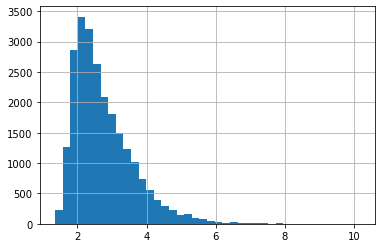

In [1046]:
A_topics.stack().hist(bins = 40)

In [1048]:
G_topics = nx.Graph(A_topics.replace(np.nan, 0).applymap(lambda x: max(x, 0)))
g = ig.Graph.from_networkx(G_topics)

topic_partition = pd.Series(
    la.find_partition(g, partition_type=la.ModularityVertexPartition).membership,
    index = g.vs.get_attribute_values('_nx_name')) + 1

print(topic_partition.max())

# im = infomap.Infomap()
# im.add_networkx_graph(G_topics)
# im.run()

# topic_partition = im.get_dataframe(['name','module_id']).set_index('name').module_id

1


In [1037]:
topic_partition

ACCURACY IN ACADEMIA                                     1
ACCURACY IN MEDIA                                        1
ACTON INSTITUTE FOR THE STUDY OF RELIGION AND LIBERTY    1
ADVOCATES FOR SELF GOVERNMENT                            1
ALASKA POLICY FORUM                                      1
                                                        ..
WESTERN STATES PETROLEUM ASSOCIATION                     2
WYOMING LIBERTY GROUP                                    1
YANKEE INSTITUTE FOR PUBLIC POLICY                       2
YOUNG AMERICA'S FOUNDATION                               1
YOUNG AMERICANS FOR LIBERTY                              1
Length: 156, dtype: int64

Text(0.5, 1.0, '$\\bf{Figure~2.}$ Communities inferred from topic proportions.')

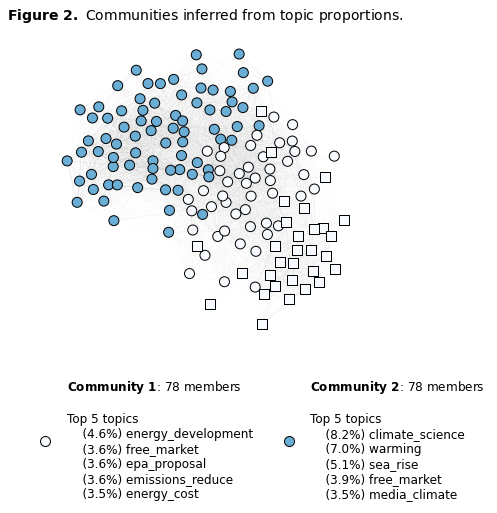

In [1026]:
cmap = 'Blues'

pos = nx.spring_layout(G_topics, k = 10, iterations = 2000, weight = 'weight', seed = 42)

ew = [e[2]['weight'] for e in G_topics.edges(data = True)] 

fig, ax = plt.subplots(1,1, figsize = (6,6))

g1 = G_topics.subgraph([n for n in G_topics if orgtypes[n] in ('501(c)(3)', '501(c)(4)')])
g2 = G_topics.subgraph([n for n in G_topics if orgtypes[n] in ('501(c)(5)', '501(c)(6)')])
nodes = nx.draw_networkx_nodes(g1, ax = ax, pos = pos, node_color = topic_partition.reindex(g1), node_size = 100, 
                               cmap = cmap, vmin = 1, vmax = topic_partition.max() + 1, node_shape = 'o')
nodes.set_edgecolor('k')
cmap = nodes.cmap

nodes = nx.draw_networkx_nodes(g2, ax = ax, pos = pos, node_color = topic_partition.reindex(g2), node_size = 100, 
                               cmap = cmap, vmin = 1, vmax = topic_partition.max() + 1, node_shape = 's')
nodes.set_edgecolor('k')
edges = nx.draw_networkx_edges(G_topics, ax = ax, pos = pos, width = ew, 
                               edge_color = [(0.25,0.25,0.25,w) for w in ew])

legend_markers = [
    Line2D(
        [0],                          
        [0],                          
        mfc=nodes.cmap(nodes.norm(m)),                          
        markersize = 100**0.5,                          
        lw = 0,                          
        marker = 'o',                          
        mec = 'k'
    )  
    for m in sorted({*topic_partition})
]

top_members = {}

for m in sorted({*topic_partition}):
    t_m = topic_partition[topic_partition == m]
    G_m = G_topics.subgraph(t_m.index.values)
    centrality = pd.Series(dict(nx.closeness_centrality(G_m, distance = 'distance')))
    
    tp = topicprops[topicprops.org.map(topic_partition) == m]
    tp_avg = tp.drop('org', axis = 1).mean().reindex(retainedtopics)
    
    top_members[m] = (
    (
        topic_partition == m).sum(),
        '\n   '.join([f" (%.1f%%) "%(a * 100) + topiclabels.set_index('topic').label[label] 
                      for label, a in tp_avg.sort_values()[:-6:-1].iteritems()])
    )

legend_titles = [r"$\bf{Community~" + str(m)+r"}$:" + f" {N} members\n\nTop 5 topics\n   {topics}" 
                 for m, (N, topics) in top_members.items()]
ax.invert_xaxis()
ax.legend(legend_markers, legend_titles, ncol = 3, loc='upper center', bbox_to_anchor=(0.66, -0.05), frameon = False, fontsize = 12)

# Add the title and remove the plot edges
[ax.spines[s].set_visible(False) for s in ax.spines]

ax.set_title(r"$\bf{Figure~2.}$ Communities inferred from topic proportions.", fontsize = 14)

# Funding for members of different topic communities

In [978]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score

adjusted_mutual_info_score(combined.dropna().interlock_group, combined.dropna().topic_group)

0.33821532268888505

In [562]:
df_rev = pd.read_csv('data/yearlyrevenue.csv').set_index('ORG').interpolate(axis = 1)
df_grants = pd.read_csv('data/GRANTS.csv')
df_fdn = pd.read_csv('data/FOUNDATION_METADATA.csv')
grants = df_grants.copy()
grants['GRANTMAKER'] = grants.GRANTMAKER.map(df_fdn.set_index('ORG').COMBINE_NAME)
grants = grants[~grants.GRANTMAKER.isna()]

In [563]:
p = topicprops[retainedtopics]

org_topics = p.join(topicprops.org).groupby(['org']).sum().T
org_topics.index = org_topics.index.map(topiclabels.set_index('topic').label)

D = grants.groupby(['GRANTMAKER', 'RECIPIENT']).GRANT_2020_USD.sum().reset_index(drop=False).replace(np.nan, 0)
topic_group_mean_rev = df_rev.mean(1).groupby(topic_partition).mean()
D['topic_community'] = D.RECIPIENT.map(topic_partition)
D['grantprop'] = D.GRANT_2020_USD.div(D.topic_community.map(topic_group_mean_rev))
D.groupby(['GRANTMAKER', 'topic_community']).GRANT_2020_USD.sum().unstack().replace(np.nan, 0).sort_values(2)[:-10:-1]

topic_community,1.0,2.0,3.0
GRANTMAKER,,,
DONORS TRUST & DONORS CAPITAL FUND,1.438252e+08,5.353441e+07,1.622226e+08
SEARLE FREEDOM TRUST,3.720106e+07,2.132469e+07,3.136852e+07
CHARLES KOCH INSTITUTE AND FOUNDATION,3.442231e+07,1.659605e+07,2.130438e+07
DUNN FOUNDATION THE,3.119985e+07,1.425003e+07,6.272824e+06
JOHN TEMPLETON FOUNDATION,2.048058e+07,1.232795e+07,3.252282e+07
FIDELITY CHARITABLE GIFT FUND,2.565009e+07,1.011662e+07,1.801584e+07
LAURA AND JOHN ARNOLD FOUNDATION,2.590182e+05,6.829329e+06,2.816860e+06
SCAIFE FAMILY FOUNDATIONS,5.694671e+07,6.695487e+06,5.655507e+07
ADOLPH COORS FOUNDATION,6.445119e+06,4.753426e+06,6.277457e+06


# Edge correlations between topics and interlocks

In [992]:
closeness_data = []

D = G_interlocks
V = list(D.nodes)

for i in range(len(D)):
    for j in range(i + 1, len(D)):
        d = nx.shortest_path_length(D, V[i], V[j], weight='distance')
            
        closeness_data.append([V[i], V[j], d])
        closeness_data.append([V[j], V[i], d])
        
A_interlocks = pd.DataFrame(closeness_data).set_index([0,1]).unstack()
A_interlocks.columns = A_interlocks.columns.droplevel()

In [997]:
p = topicprops[retainedtopics].copy()
p = p.div(p.sum(1), 0)

org_topics = p.join(topicprops.org).groupby(['org']).mean().T

A_topics = org_topics.corr(method = jensenshannon)
np.fill_diagonal(A_topics.values, np.nan)

overlap = {*A_topics.index} & {*A_interlocks.index}

y = A_topics.T.reindex(index=overlap, columns=overlap)
y = y.where(np.tril(np.ones(y.shape)).astype(bool)).stack()

x = A_interlocks.reindex(index=overlap, columns=overlap)
x = x.where(np.tril(np.ones(x.shape)).astype(bool)).stack().sort_values()

y = y.reindex(x.index)

y_cons_noncons = y[y.index.map(lambda u: 
                  (interlock_partition.get(u[1]) != interlock_partition.get(u[0])) &
                  ((interlock_partition.get(u[0]) == 1) | (interlock_partition.get(u[1]) == 1))
                 )]

x_cons_noncons = x[x.index.map(lambda u: 
                  (interlock_partition.get(u[1]) != interlock_partition.get(u[0])) &
                  ((interlock_partition.get(u[0]) == 1) | (interlock_partition.get(u[1]) == 1))
                 )]

y_diff_groups = y[y.index.map(lambda u: 
                  (interlock_partition.get(u[1]) != interlock_partition.get(u[0]))
                 )]

x_diff_groups = x[x.index.map(lambda u: 
                  (interlock_partition.get(u[1]) != interlock_partition.get(u[0]))
                 )]

Text(0.5, 1.0, '$\\bf{Figure~4a.}$ Interlocks predict topic similarity (exponential weight).\n')

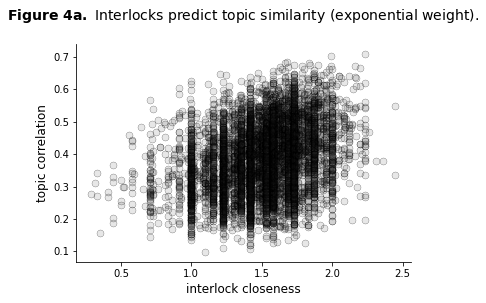

In [998]:
plt.figure(figsize = (6, 4))

plt.plot(x**0.5, 
         y, 
         lw = 0, 
         ms = 7, 
         marker = 'o', 
         mec = 'k', 
         zorder = -1, 
         mfc = (0.1,0.1,0.1,0.1), 
         markeredgewidth = 0.2)
    
ax = plt.gca()

[ax.spines[s].set_visible(False) for s in ('top', 'right')]
ax.set_xlabel(r'interlock closeness', fontsize = 12)
ax.set_ylabel('topic correlation', fontsize = 12)
ax.set_title(r"$\bf{Figure~4a.}$"+" Interlocks predict topic similarity (exponential weight)."+"\n", fontsize = 14)

Text(0.5, 1.0, '$\\bf{Figure~3.}$ Interlock distance predicts topic distance')

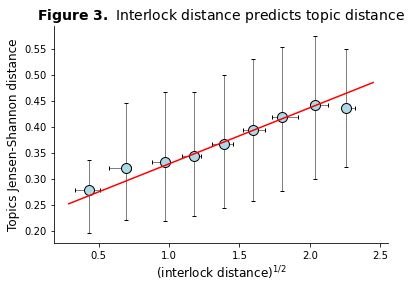

In [1003]:
data = pd.DataFrame({'x': x**0.5, 'y': y})
bins = pd.cut(data.x, np.linspace(min(data.x), max(data.x), 10))

fig, ax = plt.subplots()

means = data.groupby(bins).mean()
counts = data.groupby(bins).apply(len)
err = data.groupby(bins).quantile([0.1, 0.9]).unstack()

ax.errorbar(means.x, 
            means.y, 
            xerr = abs(means.x - err.x.T),
            yerr = abs(means.y - err.y.T), 
            fmt = 'o', 
            mec = 'k',
            mfc = 'lightblue',
            ms = 10,
            elinewidth = 0.5,
            ecolor = 'k',
            capsize = 2,
           )

exog = sm.add_constant(data.x)
model = sm.OLS(endog = data.y, exog = exog)
fit = model.fit()
robust = fit.get_robustcov_results('HC3')

linx = np.linspace(min(data.x), max(data.x))
ax.plot(linx, fit.params[0] + fit.params[1] * linx, color = 'r', zorder = 100)

[ax.spines[s].set_visible(False) for s in ('top', 'right')]
ax.set_xlabel('(interlock distance)$^{1/2}$', fontsize = 12)
ax.set_ylabel('Topics Jensen-Shannon distance', fontsize = 12)
ax.set_title(r"$\bf{Figure~3.}$ Interlock distance predicts topic distance", fontsize = 14)

0.08603720823753058

Text(0.5, 1.0, '$\\bf{Figure~4b.}$Interlocks predict topic similarity.\n(Binned logged closeness)')

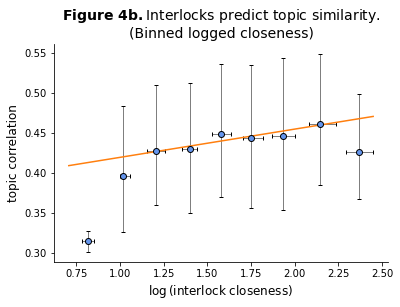

In [611]:
data = pd.DataFrame({'x': x_diff_groups**-0.5, 'y': y_diff_groups})
bins = pd.cut(data.x, np.linspace(min(data.x), max(data.x), 10))

fig, ax = plt.subplots()

means = data.groupby(bins).mean()
counts = data.groupby(bins).apply(len)
err = data.groupby(bins).quantile([1/6, 5/6]).unstack()

ax.errorbar(means.x, 
            means.y, 
            xerr = abs(means.x - err.x.T),
            yerr = abs(means.y - err.y.T), 
            fmt = 'o', 
            mec = 'k',
            mfc = 'cornflowerblue',
            elinewidth = 0.5,
            ecolor = 'k',
            capsize = 2,
           )

exog = sm.add_constant(data.x)
model = sm.OLS(endog = data.y, exog = exog)
fit = model.fit()

linx = np.linspace(min(data.x), max(data.x))
ax.plot(linx, robust.params[0] + robust.params[1] * linx)

[ax.spines[s].set_visible(False) for s in ('top', 'right')]
ax.set_xlabel('$\log$(interlock closeness)', fontsize = 12)
ax.set_ylabel('topic correlation', fontsize = 12)
ax.set_title(r"$\bf{Figure~4b.}$"+
             "Interlocks predict topic similarity."+
             "\n(Binned logged closeness)", fontsize = 14)

Text(0.5, 1.0, '$\\bf{Figure~4c.}$Interlocks predict topic similarity between\ngroups in different interlock communities.')

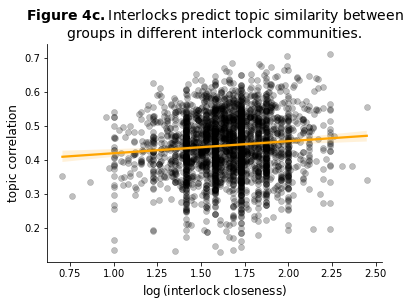

In [613]:
data = pd.DataFrame({'x': x_diff_groups**-0.5, 'y': y_diff_groups})

sns.regplot(data = data.set_index(data.x),
            x= 'x', 
            y='y', 
            ci = 99, 
            line_kws = dict(color = 'orange'),
            scatter_kws = dict(color = 'k', lw = 0.5, alpha = 0.25),
            order = 1
           )

ax = plt.gca()

[ax.spines[s].set_visible(False) for s in ('top', 'right')]
ax.set_xlabel('$\log$(interlock closeness)', fontsize = 12)
ax.set_ylabel('topic correlation', fontsize = 12)
ax.set_title(r"$\bf{Figure~4c.}$"+
             "Interlocks predict topic similarity between\ngroups in different interlock communities.", fontsize = 14)

Text(0.5, 1.0, '$\\bf{Figure~4d.}$Interlocks predict topic similarity between\nconservative movement and other groups.')

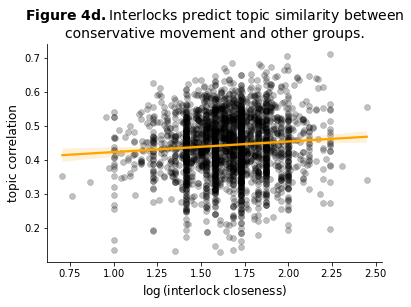

In [609]:
data = pd.DataFrame({'x':x_cons_noncons**-0.5, 'y':y_cons_noncons})

sns.regplot(data = data.set_index(data.x),
            x= 'x', 
            y='y', 
            ci = 99, 
            line_kws = dict(color = 'orange'),
            scatter_kws = dict(color = 'k', lw = 0.5, alpha = 0.25),
            order = 1
           )

ax = plt.gca()

[ax.spines[s].set_visible(False) for s in ('top', 'right')]
ax.set_xlabel('$\log$(interlock closeness)', fontsize = 12)
ax.set_ylabel('topic correlation', fontsize = 12)
ax.set_title(r"$\bf{Figure~4d.}$"+
             "Interlocks predict topic similarity between\nconservative movement and other groups.", fontsize = 14)